# CSP Cleaning Optimization Demonstration
Core optimization functions are located in the [`cleaning_optimization.py`](soiling_model/cleaning_optimization.py) module:
This demonstration walks through two different cleaning heuristic techniques for the optimization and evaluation of cleaning resources for concentrated solar power (CSP) plants. Cleaning speeds can be either manually set within the parameters.xlsx file or automatically calculated based on the field layout and cleaning operation specifications.

## 1. Periodic Schedule Optimization
[`optimize_periodic_schedule()`][opt_peri] optimizes cleaning fleet size by:
- Finding minimum total cleaning cost configuration
- Automatic search bounds determination
- Returns optimal truck count and cleaning frequency

[`periodic_schedule_tcc()`][perio_tcc] simulates cleaning operations by:
- Taking current number of trucks and cleaning frequency as input
- Evaluating cost and performance metrics

[opt_peri]: soiling_model/cleaning_optimization.py#L104
[perio_tcc]: soiling_model/cleaning_optimization.py#L198


### Process
1. **Search Bounds Determination**
   - Finds minimum viable trucks needed
   - Calculates maximum possible cleanings per configuration
   - Sets search range ±2 trucks from optimal point

2. **Grid Search**
   - Evaluates all valid combinations within bounds
   - Calculates total cleaning costs (TCC):
     - Direct cleaning costs (labor, maintenance, consumables)
     - Degradation costs (lost power production)
   - Identifies global minimum cost solution

3. **Outputs**
   - Optimal number of trucks
   - Optimal cleaning frequency
   - Complete cleaning schedule
   - Cost breakdown and performance metrics

## 2. Rollout Heuristic Optimization
Looks over a dynamic horizon (set by the number of cleaning crews used) and sets the cleaning schedule and cleans heliostat sectors based upon the profitability of each action (greedy algorithm)
[`optimize_rollout_schedule()`][opt_roll] optimizes the number of cleaning crews by:
- Running rollout simulations across truck counts
- Finding minimum cost configuration
- Expanding search bounds if needed
- Returns optimal cleaning fleet size

[`rollout_heuristic_tcc()`][roll_tcc] simulates cleaning operations by:
- Taking current number of trucks as input for rollout optimization

[opt_roll]: soiling_model/cleaning_optimization.py#L319
[roll_tcc]: soiling_model/cleaning_optimization.py#L415

### Process
1. **Daily Optimization**
   - Evaluates current field condition
   - Predicts future soiling impact
   - Calculates revenue for each sector cleaning action

2. **Decision Making**
   Currently one available methods:
   - **Greedy**: Selects highest immediate benefit sector to clean

3. **Constraints**
   - Truck availability
   - Sectors per truck capacity
   - Horizon set to days it takes to clean the full field with current truck fleet

### Visualization Tools
The demo includes several visualization functions:
- [`plot_optimization_results()`][opt_plot]: Shows total cleaning cost and optimal cleaning setup across search bounds
- [`plot_soiling_factor()`][soil_plot]: Displays soiling factor across cleaning schedule simulation timeframe
- [`plot_cleaning_schedule()`][clean_plot]: Shows cleaning schedule against heliostat sector
- [`plot_soiled_optical_efficiency()`][eff_plot]: Illustrates efficiency impacts

[opt_plot]: soiling_model/cleaning_optimization.py#L922
[soil_plot]: soiling_model/cleaning_optimization.py#L1005
[clean_plot]: soiling_model/cleaning_optimization.py#L1067
[eff_plot]: soiling_model/cleaning_optimization.py#L1113
## Comparative Analysis
The demo allows comparison between:
- Fixed periodic vs rollout scheduling
- Cost effectiveness of different strategies
- Impact on plant performance
- Resource utilization efficiency

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from tqdm.notebook import tqdm
from matplotlib import (rcParams,dates,colors,ticker)
from matplotlib.dates import DateFormatter
rcParams['figure.figsize'] = (15, 7)
import soiling_model.cleaning_optimization as co

In [62]:
# File directories
d = "woomera_demo/" # Folder containing all the files for the woomera_demo
params = d+"parameters_carwarp.xlsx" # Config parameters file
weather = d+'carwarp_data.xlsx' # weather file containing tsp, wind speed, temperature timeseries data
SF = d+'Solarfield_carwarp.csv' # solarpilot generated solar field located in Woomera
climate_file = d+'carwarp_location.epw' # solarpilot weather file with latitude, longitude and UTC corrected for Woomera
sigma = 2.0
electrical_efficiency_file = f'C:\\Users\\n12118907\\OneDrive - Politecnico di Milano\\PhD 2024\\CPV performance\\lookup_table_files\\eta_el\\eta_el_{sigma}.csv'
thermal_efficiency_file = f'C:\\Users\\n12118907\\OneDrive - Politecnico di Milano\\PhD 2024\\CPV performance\\lookup_table_files\\eta_th\\eta_th_{sigma}.csv'
cleaning_rate = None # Heliostats cleaned per cleaning crew per shift, Can leave as None to calculate using cleaning truck config parameters and solar field characteristics
n_sol_az = 10   # number of solar azimuth angles for the efficiency lookup table
n_sol_el = 10  # number of solar elevation angles for the efficiency lookup table
second_surface = True # second_surface = False uses a first-surface model for the reflectance loss
model_type = 'semi-physical' # semi-physical or simplified
n_modules = 4 # Number of arrays in the plant. Set to 1 if there is just one array

Build soiling model, import inputs, and sectorize the field

In [63]:
opt = co.optimization_problem(  params,
                                SF,
                                weather,climate_file,
                                cleaning_rate=cleaning_rate,
                                dust_type="PM2.5",
                                second_surface=second_surface,
                                n_az=n_sol_az,
                                n_el=n_sol_el,
                                verbose=True,
                                model_type=model_type,
                                ext_options={'grid_size_x':250},
                                n_modules = n_modules,
                                electrical_efficiency_file=electrical_efficiency_file,
                                thermal_efficiency_file=thermal_efficiency_file)

Importing site data (weather,time). Using dust_type = PM2.5, test_length = -1 days
Importing T1 data as air_temp...
Importing WS data as wind_speed...
Importing RH data as relative_humidity...
Importing WD data as wind_direction...
Importing pm_tot data...
Importing pm10 data...
Importing pm2p5 data...
Length of simulation for file woomera_demo/carwarp_data.xlsx: -1 days
Importing dust properties for each experiment
Added PM2_5 attribute to dust class to all experiment dust classes
Loading source (normalized) intensity from woomera_demo/carwarp_data.xlsx

Loading data from woomera_demo/parameters_carwarp.xlsx ... 

Importing constants
Calculated cleaning rate: 863.8 heliostats/shift
Grid size: 2 x 3 = 6 sectors
Sectors per truck: 6
Effective cleaning rate: 283.0 heliostats/shift
Error from target: 0.0%
Sectorizing with 2 horizontal and 3 vertical sectors
Clustering heliostats...
Calculating sun apparent movement and angles for 1 simulations


c:\Users\n12118907\AppData\Local\miniconda3\envs\cpv_sim\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\n12118907\OneDrive - Queensland University of Technology\Documents\GitHub\HelioSoil\soiling_model\field_models.py:204: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  time_utc = [t.replace(tzinfo=timezone) for t in np.array(sim_in.time[f].dt.to_pydatetime())]
c:\Users\n12118907\AppData\Local\miniconda3\envs\cpv_sim\Lib\site-packages\pysolar\solartime.py:113: UserWarning: I don't know about leap seconds after 2023
  warnings.warn \
c:\Users\n12118907\AppData\Local\minicond

No DNI in weather data file using clear sky DNI
Calculating heliostat movement and angles for 1 simulations
Second surface model
Acceptance angle range: (7.2, 14.2) [mrad]
No value for hrz0 supplied. Using value in self.hrz0 = 8.41.
Calculating deposition velocity for each of the 1 simulations
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  Using common stow_tilt. Assumes all heliostats are stored at helios.stow_tilt at night.
Calculating soil deposited in a timestep [m^2/m^2]


Computing optical efficiency grid:   0%|          | 0/100 [00:00<?, ?it/s]

Computing optical efficiency time series for file 0
Done!


Examine DNI statistics for a certain experiment

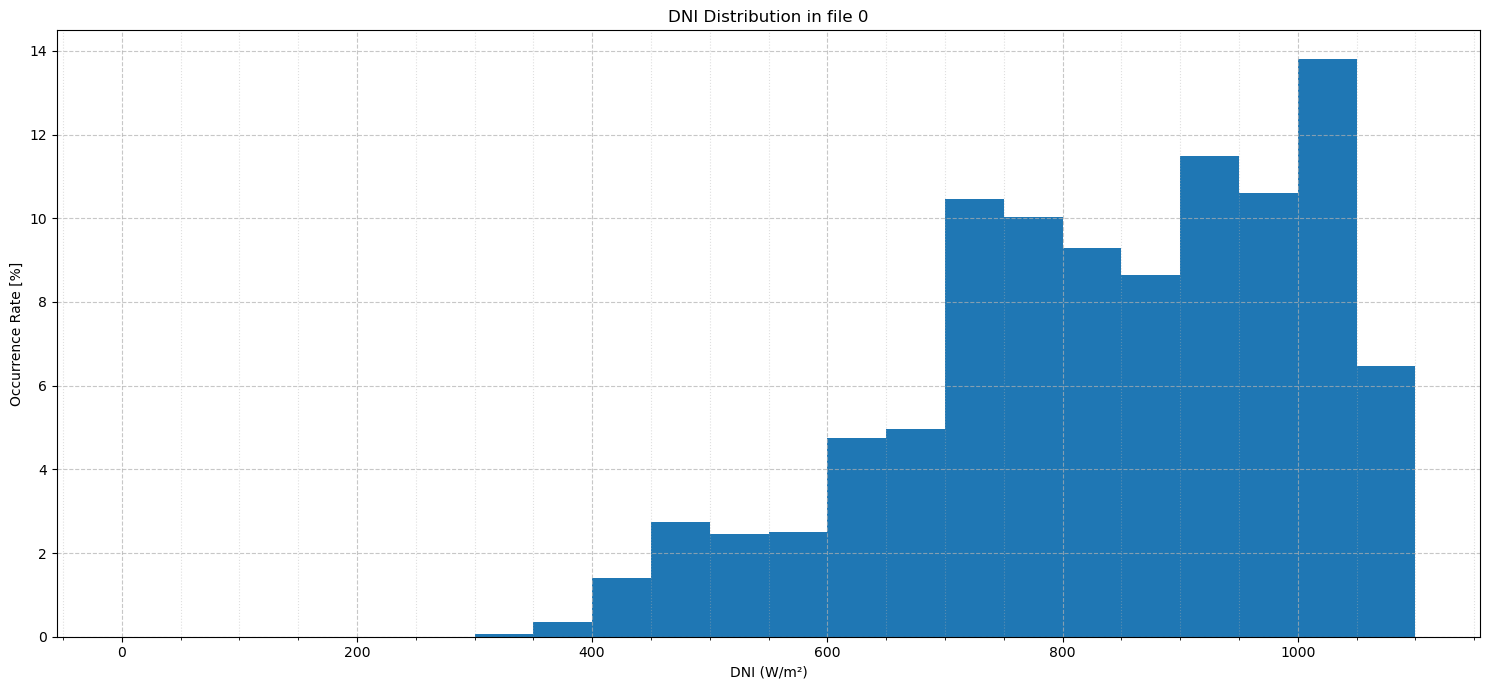

In [64]:
f = 0
DNI = opt.simulation_data.dni[f].copy()
se = opt.field_model.sun.elevation[f]
DNI[se<opt.field_model.sun.stow_angle] = np.nan

fig, ax = plt.subplots()
# Calculate weights to normalize to percentage
weights = np.ones_like(DNI[~np.isnan(DNI)]) * 100 / len(DNI[~np.isnan(DNI)])

# Plot normalized histogram
ax.hist(DNI[~np.isnan(DNI)], 
        bins=np.arange(0, np.nanmax(DNI) + 50, 50), 
        weights=weights,
        align='mid')

ax.grid(True, linestyle='--', alpha=0.7)
ax.grid(True, which='minor', linestyle=':', alpha=0.4)
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_title(f"DNI Distribution in file {f}")
ax.set_xlabel("DNI (W/m²)")
ax.set_ylabel("Occurrence Rate [%]")

plt.tight_layout()

Calculate bounds for field-averaged optical efficiency to provide full power under various DNI conditions

(<Figure size 1200x1000 with 1 Axes>,
 <Axes: title={'center': 'Solar Field Sectors'}, xlabel='Distance from receiver - X [m]', ylabel='Distance from receiver - Y [m]'>)

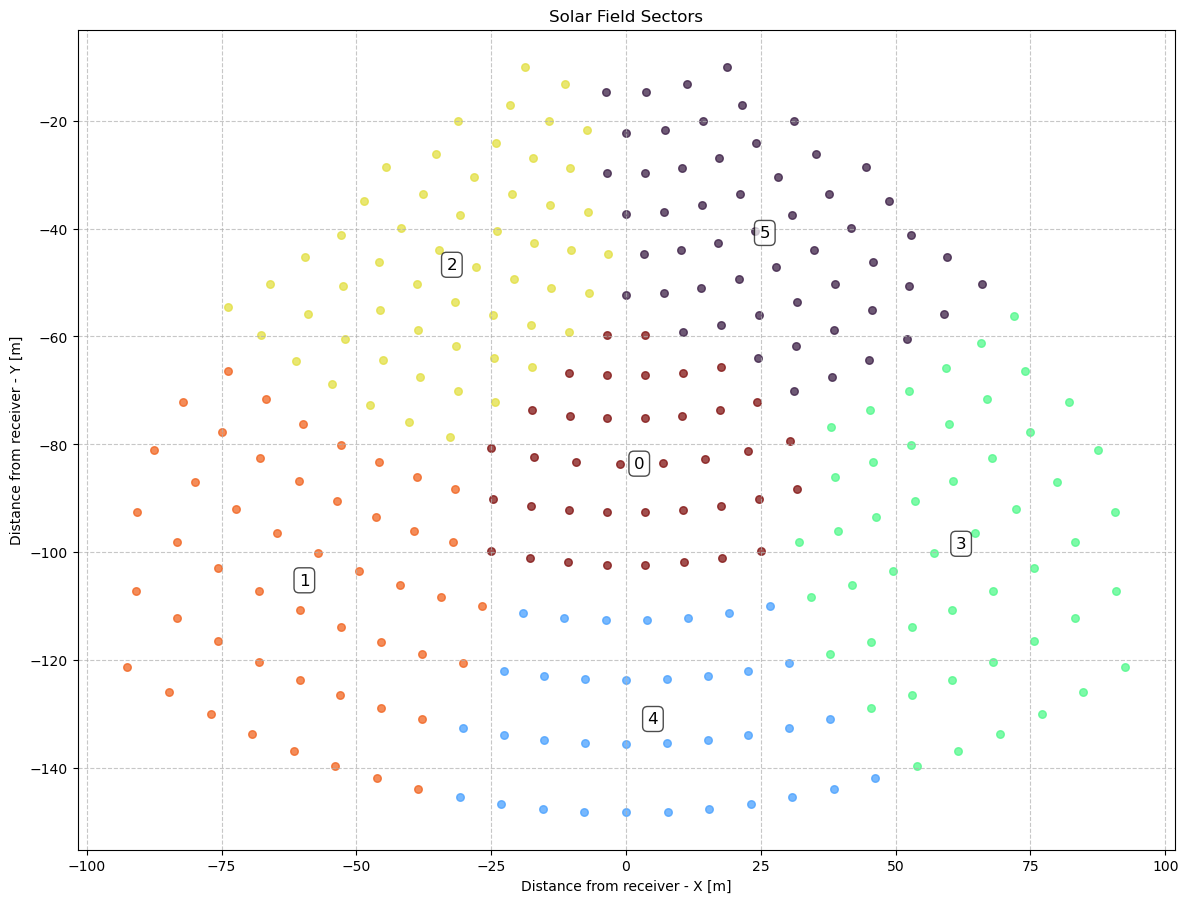

In [65]:
opt.field_model.helios.sector_plot(show_id=True, cmap_name='turbo_r')

Examine the soiling losses for each representative heliostat over the year

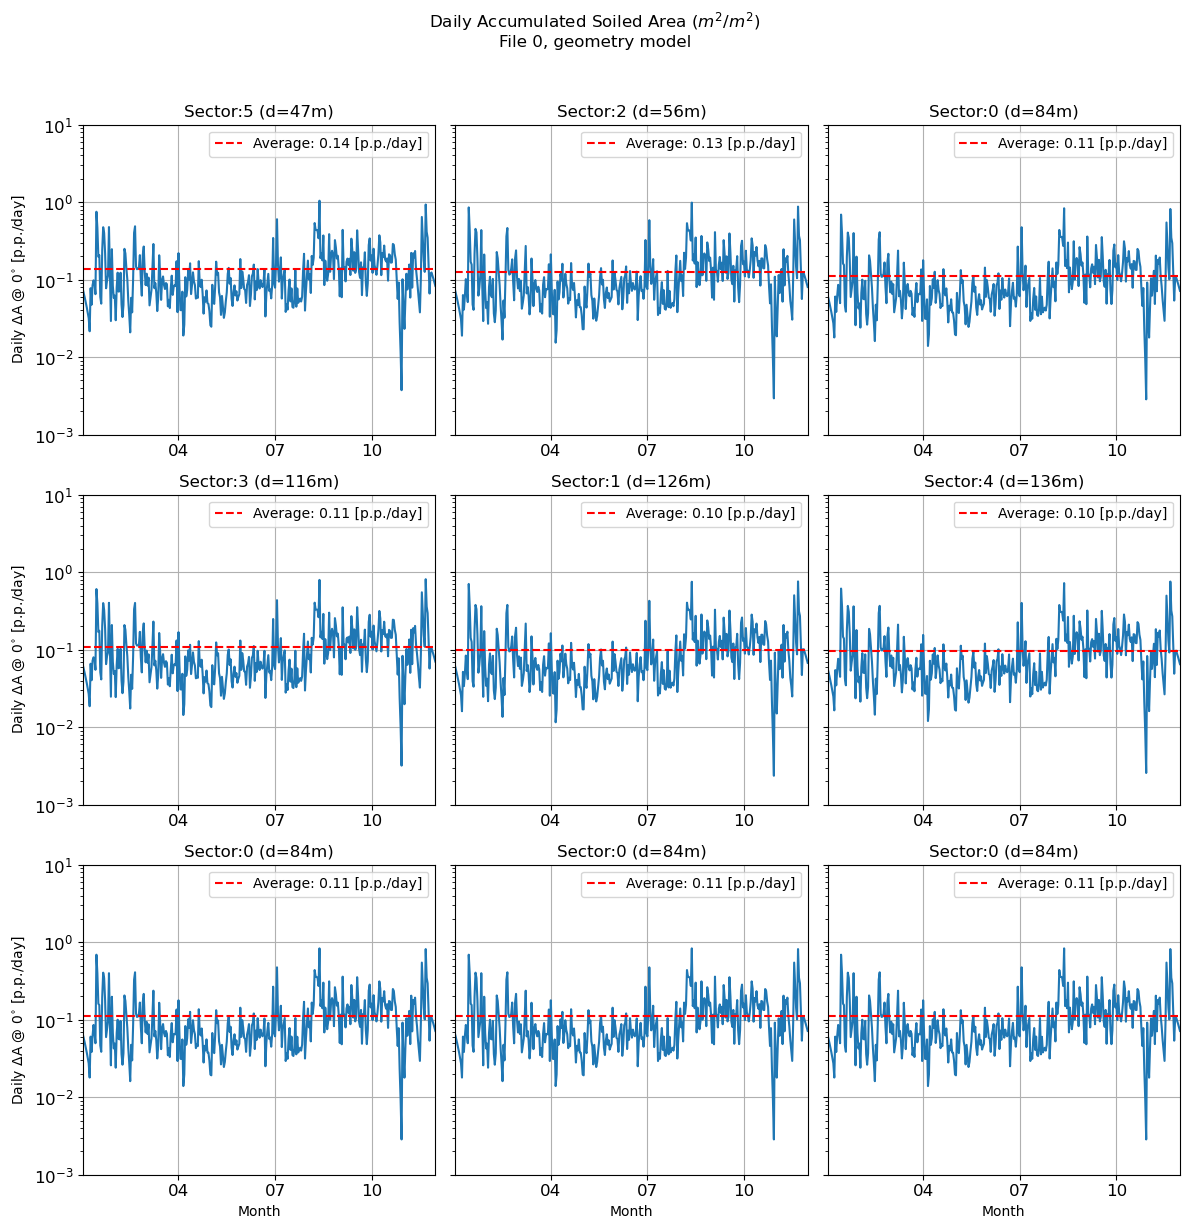

In [66]:
f = 0  # file index
nrows, ncols = 3, 3  # 3x3 grid for 9 heliostats
n_helios = nrows * ncols
n_helios_total = len(opt.field_model.helios.y)
# Calculate distances from receiver for all heliostats
distances = np.sqrt(opt.field_model.helios.x**2 + opt.field_model.helios.y**2)

# Find min and max distances
d_min, d_max = np.min(distances), np.max(distances)

# Select target distances evenly spaced between min and max
target_distances = np.linspace(d_min, d_max, n_helios)

# Find heliostats closest to target distances
helios_indices = []
for target_d in target_distances:
    # Find heliostat with distance closest to target
    idx = np.argmin(np.abs(distances - target_d))
    # Avoid duplicates by marking selected distances as invalid
    distances[idx] = np.inf
    helios_indices.append(idx)

helios_indices = np.array(helios_indices)
time_vector = opt.simulation_data.time[f]

# Convert datetime to day of year
days = np.array([t.timetuple().tm_yday for t in time_vector])
unique_days = np.unique(days)

# Initialize array for daily sums
daily_soil_rate = np.zeros((n_helios_total, len(unique_days)))
# Sum delta_soiled_area for each day
for i, day in enumerate(unique_days):
    day_mask = days == day
    daily_soil_rate[:, i] = np.sum(opt.field_model.helios.delta_soiled_area[f][:, day_mask], axis=1)

# Create subplot grid
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, figsize=(12, 12))

# Plot daily values for selected heliostats
for i, h in enumerate(helios_indices):
    r, c = i // ncols, i % ncols
    
    # Plot data
    ax[r,c].plot(unique_days, daily_soil_rate[h,:]*100, '-')
    # Calculate and plot average line
    average = np.mean(daily_soil_rate[h,:]*100)
    ax[r,c].axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f} [p.p./day]')
    ax[r,c].legend(fontsize=10)
    ax[r,c].set_title(f'Sector:{h} (d={np.sqrt(opt.field_model.helios.x[h]**2 + opt.field_model.helios.y[h]**2):.0f}m)')
    
    # Set y-limits and ticks for log scale
    ymax = 10**(np.ceil(np.log10(np.max(daily_soil_rate*100))))
    ymin = 10**(np.floor(np.log10(np.min(daily_soil_rate[daily_soil_rate > 0]*100))))
    ax[r,c].set_ylim(ymin, ymax)
    ax[r,c].set_yscale('log')
    # Add y-label only for leftmost column
    if c == 0:
        ax[r,c].set_ylabel(r"Daily $\Delta$A @ $0^{\circ}$ [p.p./day]")
    
    ax[r,c].set_xlim([unique_days[0], unique_days[-1]])
    ax[r,c].tick_params(axis='both', which='major', labelsize=12)
    ax[r,c].xaxis.set_major_formatter(DateFormatter('%m'))
    # Remove x-ticks except for bottom row
    if r >= nrows-1:
        ax[r,c].set_xlabel('Month')
        
    ax[r,c].grid(True)

# Add overall title
fig.suptitle(f"Daily Accumulated Soiled Area "+ r"($m^2$/$m^2$)"+
             f"\nFile {f}, {opt.field_model.loss_model} model", 
             y=1.02)

plt.tight_layout()

# Periodic Schedule Optimization
The Periodic Schedule specified by $n_{trucks}$ and $n_{cleans}$ is subsequently applied. This follows the *Heuristic Approach* described in [3] from README.md.
Optimization of cleaning operations for a concentrated solar power plant is determined by adapting the:
- Number of cleaning trucks (Time it takes to clean the full plant)
- Number of cleanings per year (Amount of times each heliostat is cleaned throughout the year)
- Cleaning schedule for each sector (More trucks allow for higher cleaning frequencies)
## Optimization Process
### 1. Cost Components
The total cleaning cost (TCC) is the sum of:
- **Direct Cleaning Costs**
  - Fixed costs (per truck)
    - Depreciation 
    - Maintenance
    - Operator salary
  - Variable costs (per cleaning)
    - Water consumption
    - Fuel usage
- **Degradation Costs**
  - Lost power production due to soiling
  - Calculated from reduced reflectivity
### 2. Search Strategy
1. **Truck Bounds**
   - Find a suitable range of trucks to explore costs
   - Starts with 1 truck and simulate maximimum cleaning frequency possible
   - Increases until costs rise
   - Sets bounds within +/- 2 trucks 
   2. **Cleaning Frequency Bounds**
   - Minimum: Based on field coverage requirements
   - Maximum: Physical limit of trucks' cleaning capacity

3. **Grid Search**
   - Evaluates all valid combinations within search bounds
   - Finds minimum cost solution
## Output
Returns optimized solution with:
- Optimal number of trucks
- Optimal cleaning frequency
- Optimal cost results
- Grid-searched results

In [67]:
# Optimize with new bounds
results_periodic = co.optimize_periodic_schedule(opt,verbose=True)

Optimizing periodic schedule:   0%|          | 0/100 [00:00<?, ?it/s]

Optimizing periodic schedule...
Finding truck search bounds...
Trucks: 1, Max cleanings: 91, Total cleaning cost: $264,910.91
Trucks: 2, Max cleanings: 182, Total cleaning cost: $517,033.64
Trucks: 3, Max cleanings: 273, Total cleaning cost: $627,013.89
Periodic Schedule Simulations Running Between:
Trucks: 1 to 3
Cleanings per year: 1 to 273


Optimal solution found:
Number of trucks: 1
Cleanings per year: 19
Total cleaning cost: $180,310.49/year
Direct cleaning cost: $140,534.73/year
Degradation cost: $39,775.76/year


Total cleaning costs simulation results for the periodic schedule search space. The optimal solution is that with the lowest total cleaning cost.

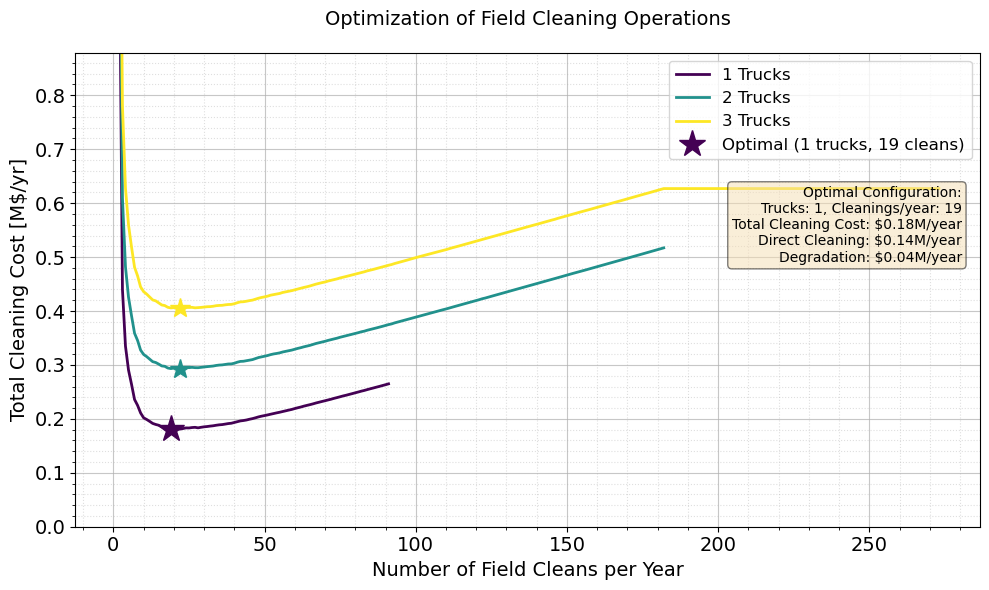

In [68]:
fig, ax = co.plot_optimization_results(results_periodic, file=f) # Plot the bounded search total cleaning cost against cleaning frequnecy for each number of trucks

Create a plot of the expected soiling factor across a steady state year simulation using the optimal periodic schedule.

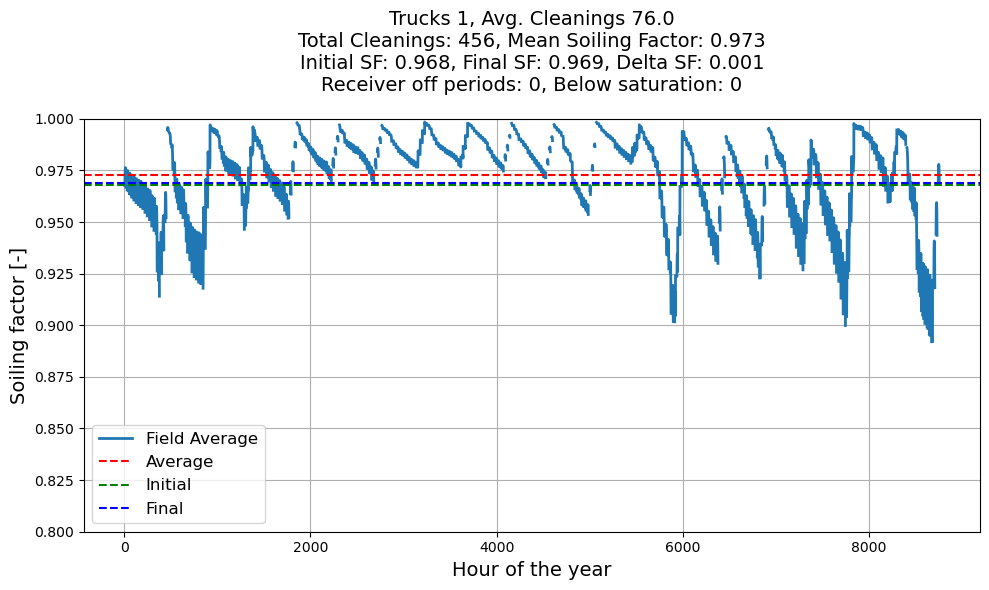

In [69]:
fig, ax = co.plot_soiling_factor(results_periodic['optimal_results'], file=f)

In [70]:
cleanliness_loss = (results_periodic['optimal_results']['soiling_factor'][0]).T

total_cleanliness = []
for j in range(cleanliness_loss.shape[0]):
    cleanliness_heliostats = []
    for i in range(len(opt.field_model.helios.full_field['x'])): # Spanno tutti gli eliostati
        cleanliness_heliostats.append(cleanliness_loss[j, opt.field_model.helios.full_field['sector_id'][i]])
    total_cleanliness.append(cleanliness_heliostats)

total_cleanliness = np.array(total_cleanliness)
total_cleanliness = np.where(np.isnan(total_cleanliness), 1, total_cleanliness)

total_cleanliness_array = pd.DataFrame(total_cleanliness)
total_cleanliness_array.to_csv(f"cleanliness_{sigma}.csv", index = True)

In [71]:
total_cleanliness

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Soiled optical efficiency

c:\Users\n12118907\OneDrive - Queensland University of Technology\Documents\GitHub\HelioSoil\soiling_model\cleaning_optimization.py:1188: RuntimeWarning: Mean of empty slice
  ax.plot(opt.simulation_data.time[file],np.nanmean(eta_soiled, axis=0),


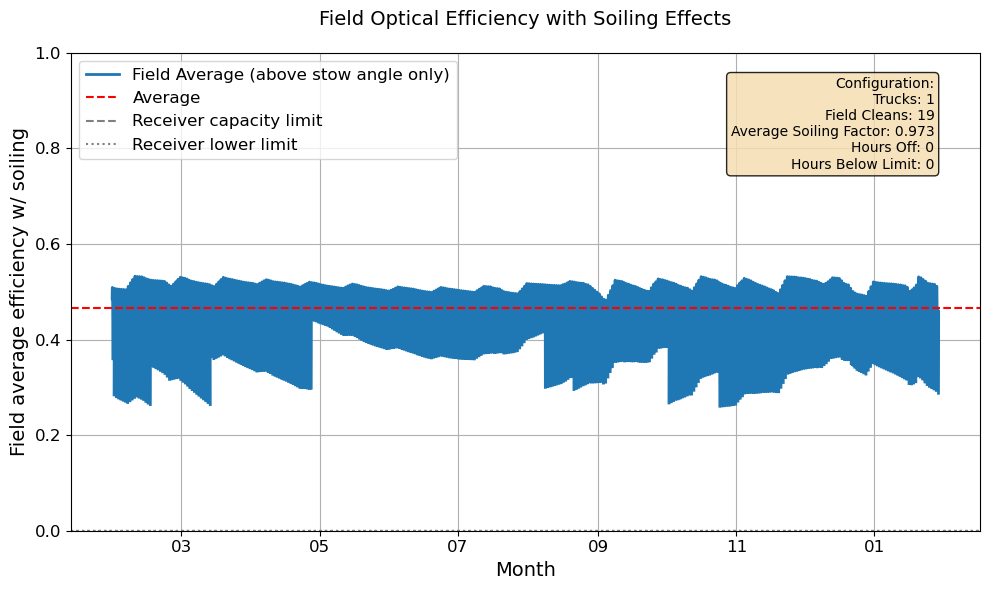

In [72]:
fig, ax = co.plot_soiled_optical_efficiency(opt, results_periodic['optimal_results'], file=f)

Create a plot of the cleaning schedule, i.e. which group of heliostats (sector) is cleaned at which day of the year for the optimal periodic schedule

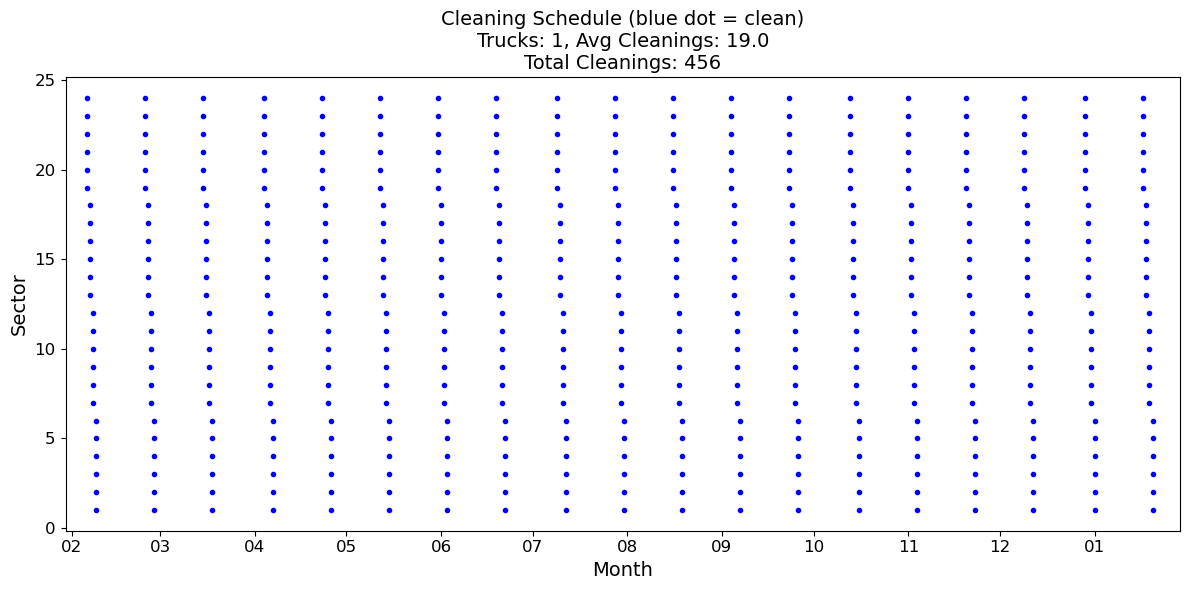

In [73]:
fig, ax = co.plot_cleaning_schedule(opt, results_periodic['optimal_results'])

We can also plot the results from one of the other simulations performed within the bounds by specifying the number of trucks and number of yearly avg cleans for each heliostat.

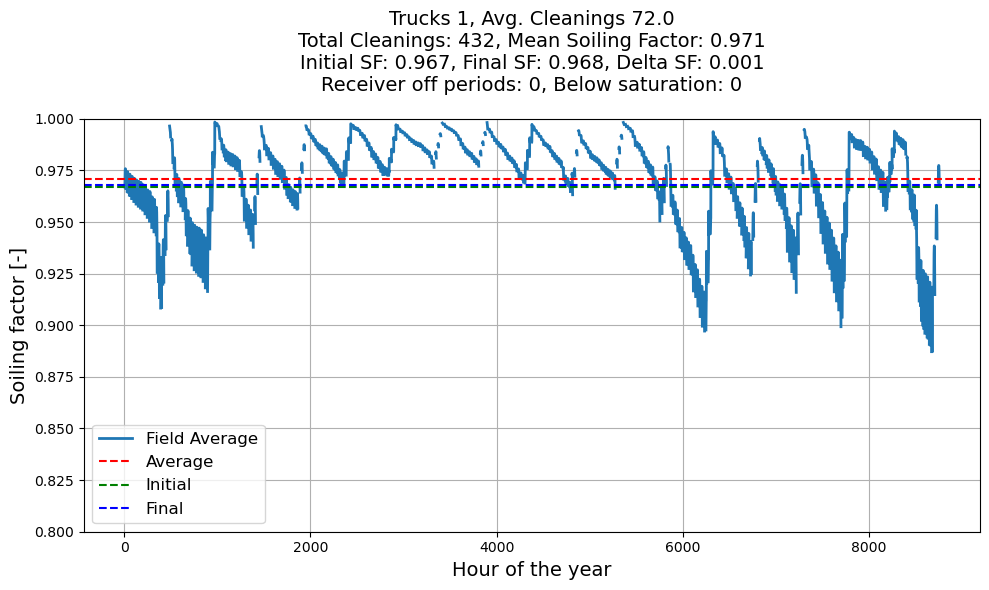

In [74]:
plot_n_trucks = 1 # number of trucks
plot_n_cleans = 18 # number of avg cleanings per year for each heliostat
unoptimal_soilfactor_fig, unoptimal_soilfactor_ax = co.plot_soiling_factor(results_periodic['all_results'][plot_n_trucks,plot_n_cleans], file=0)

If we want to search outside of the automatic range we can manually specify the range through the 'periodic_schedule_tcc' which runs one simulation with the specified number of trucks and number of cleanings.

Calculating reflectance losses with cleaning for 1 simulations
Results for simulation 0: 
  Total Cleaning Cost: 3.16e+05 [$/yr]
  Degradation Costs: 1.58e+04 [$/yr] 
  Direct Cleaning Costs: 3.00e+05 [$/yr]


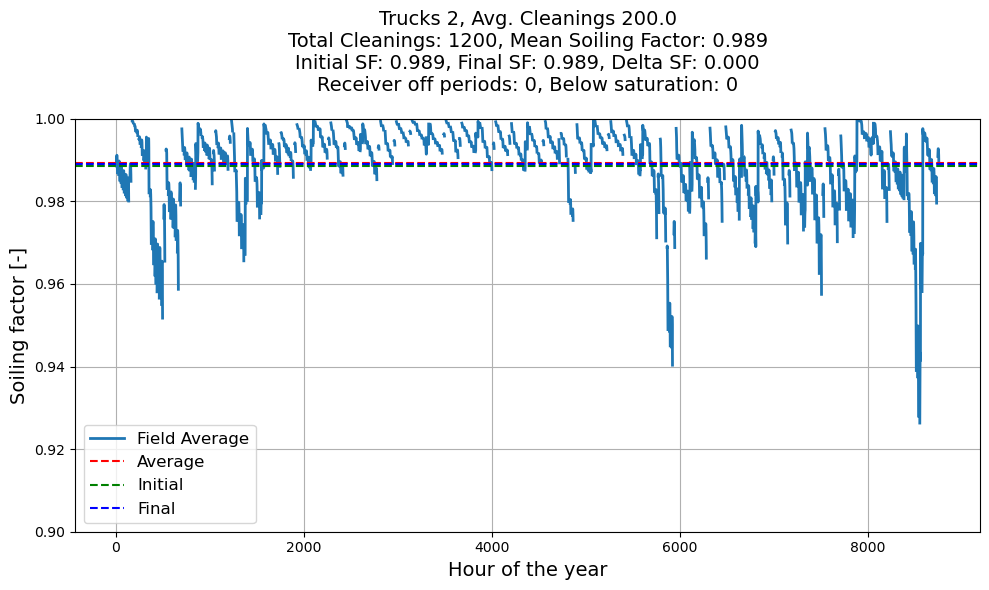

In [75]:
simulate_n_trucks = 2 # Number of trucks to simulate for 
simulate_n_cleans = 50 # Cleaning frequnecy to simulate for
simulation_periodic = co.periodic_schedule_tcc(opt, simulate_n_trucks, simulate_n_cleans) # Run one simulation with the specified n_trucks and n_cleans

simulation_fig, simulation_ax = co.plot_soiling_factor(simulation_periodic, file=0) # Plot the resulting soiling factor

## Rollout Cleaning Schedule Optimization using Heuristic Methods

This example demonstrates optimizing heliostat cleaning schedules (number of cleaning crews) in concentrated solar power (CSP) plants using a condition-based heuristic approach. The method was presented within the conferrence SolarPACES (2024) - Rome, Italy. 

### Model Overview
The model performs the following key functions:
* Evaluates current field performance and soiling impacts on reflectivity
* Forecasts energy production under different cleaning scenarios
* Analyzes cleaning costs vs performance gains
* Makes dynamic cleaning decisions based on revenue optimization (using perfect knowledge forecasting across a horizon equal the time it takes to clean the full field)

### Key Considerations
The optimization accounts for real operational constraints including:
* Limited cleaning resources
* Receiver saturation limits  
* Heliostat field layout
* Weather conditions and soiling rates
* Daily/seasonal solar variations

The heuristic uses a rolling horizon to determine optimal timing and targeting of heliostat cleaning operations while maximizing plant economics.

In [76]:
initial_arealoss=np.repeat(results_periodic['optimal_results']['arealoss'][:,0], repeats=opt.field_model.helios.truck.sectors[2], axis=0) # We want to use the same initial heliostat soiling state as the best periodic schedule for a fair comparison between the two optimizers
results_rollout = co.optimize_rollout_schedule(opt, file=0, verbose=True, initial_arealoss=initial_arealoss) # Run the rollout optimization

Optimizing rollout schedule:   0%|          | 0/100 [00:00<?, ?it/s]

Optimizing rollout schedule...
Finding truck search bounds...
Trucks: 1, Max cleanings: 91, Total cleaning cost: $264,910.91
Trucks: 2, Max cleanings: 182, Total cleaning cost: $517,033.64
Trucks: 3, Max cleanings: 273, Total cleaning cost: $627,013.89
Periodic Schedule Simulations Running Between:
Trucks: 1 to 3


Simulating Day (Greedy):   0%|          | 0/366 [00:00<?, ?it/s]

Trucks: 1, Total cleaning cost: $189,206.48


Simulating Day (Greedy):   0%|          | 0/366 [00:00<?, ?it/s]

Trucks: 2, Total cleaning cost: $335,144.75


Simulating Day (Greedy):   0%|          | 0/366 [00:00<?, ?it/s]

Trucks: 3, Total cleaning cost: $445,144.75

Optimal solution found:
Number of trucks: 1
Total cleaning cost: $189,206.48/year
Direct cleaning cost: $128,615.47/year
Degradation cost: $60,591.01/year


Rollout dynamically selects the cleaning sector to clean (or not) by attempting to maximize the expected profit over the cleaning horizon using a greedy algorithm. It considers the cost of cleaning a sector and forecasts (currently perfect knowledge) future degradation costs for a clean or no-cleaned sector. It therefore does not follow a periodic cleaning schedule...

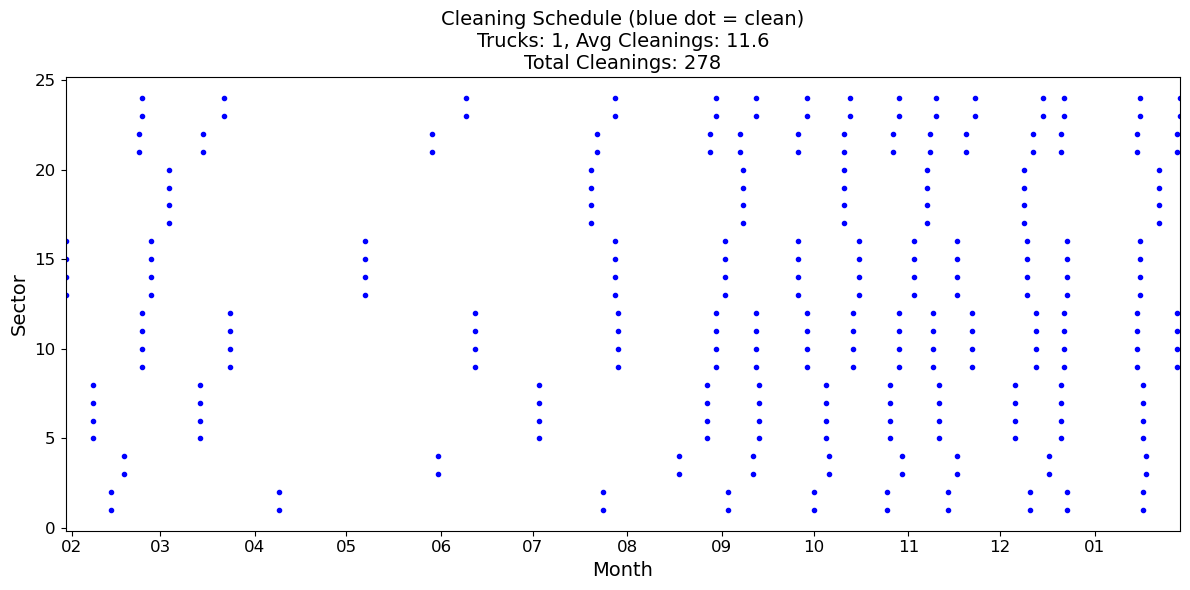

In [77]:
fig, ax = co.plot_cleaning_schedule(opt, results_rollout['optimal_results'])

Despite focusing on the maximization of plant profit. Rollout heuristic average soiling factor can be lower then the periodic cleaning, due to either a reduction in cleaning frequency to save on costs or the prioritisation of other heliostat sectors that can generate more profit.

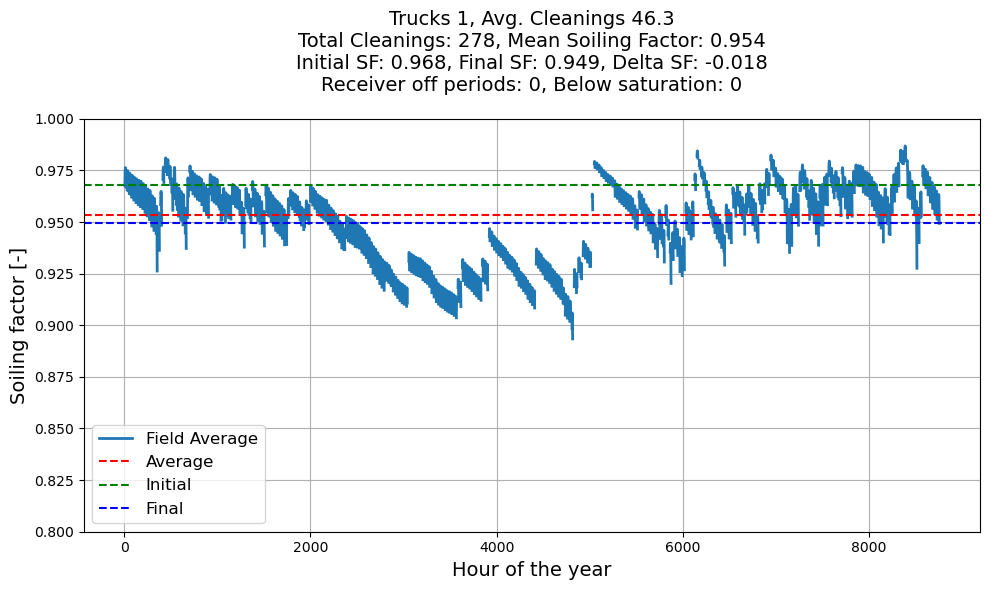

In [78]:
fig, ax = co.plot_soiling_factor(results_rollout['optimal_results'])

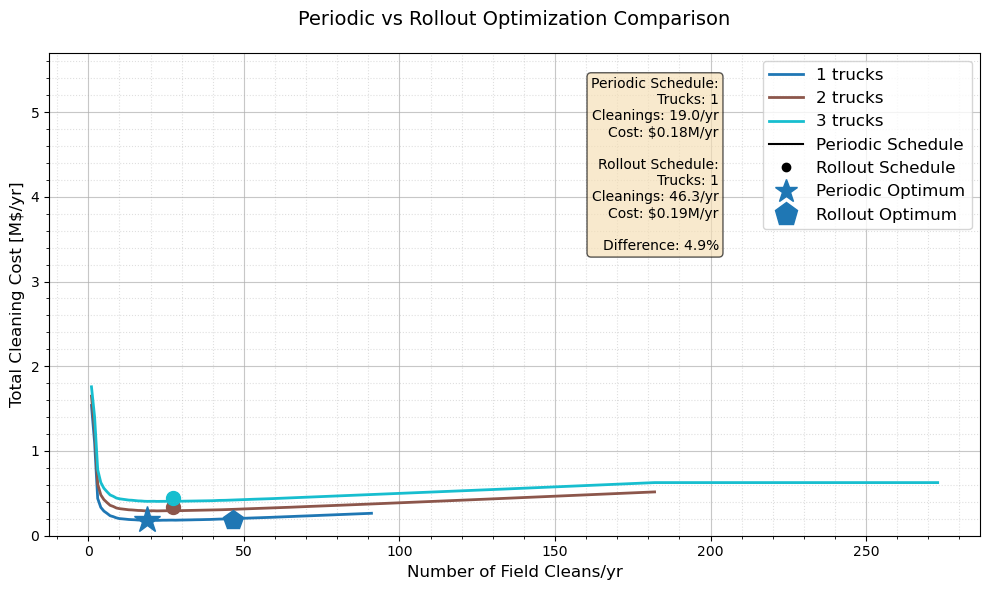

In [79]:
# Plot comparison of periodic and rollout optimization
total_sectors = opt.field_model.helios.tilt[f].shape[0]
fig, ax = plt.subplots(figsize=(10, 6))

# Create color map for all truck numbers
all_trucks = sorted(list(set(
    [k[0] for k in results_periodic['all_results'].keys()] + 
    list(results_rollout['all_results'].keys())
)))
colors = plt.cm.tab10(np.linspace(0, 1, len(all_trucks)))
truck_color_map = dict(zip(all_trucks, colors))

# Plot periodic results
for n_trucks in sorted(set(k[0] for k in results_periodic['all_results'].keys())):
    # Get cleanings and costs for this truck count
    cleans = []
    costs = []
    for (nt, nc), result in results_periodic['all_results'].items():
        if nt == n_trucks:
            cleans.append(nc)
            costs.append(result['total_cleaning_costs'][0])
    
    # Sort by number of cleans
    sort_idx = np.argsort(cleans)
    cleans = np.array(cleans)[sort_idx]
    costs = np.array(costs)[sort_idx]
    
    # Plot line
    ax.plot(cleans, costs/1e6, color=truck_color_map[n_trucks], 
            label=f"{n_trucks} trucks", linewidth=2)

# Plot rollout results
for n_trucks, result in results_rollout['all_results'].items():
    n_cleans = result['cleaning_actions'][f].sum() / total_sectors
    cost = result['total_cleaning_costs'][f]
    ax.scatter(n_cleans, cost/1e6, color=truck_color_map[n_trucks],
              s=100, marker='o')

# Get optimal configurations
p_trucks = results_periodic['optimal_trucks']
p_cleans = results_periodic['optimal_cleans']
p_cost = results_periodic['optimal_results']['total_cleaning_costs'][0]

r_trucks = results_rollout['optimal_trucks']
r_cleans = results_rollout['optimal_results']['cleaning_actions'][f].sum() / total_sectors
r_cost = results_rollout['optimal_results']['total_cleaning_costs'][f]

# Plot optimal points
ax.plot(p_cleans, p_cost/1e6, marker='*', markersize=20,
        color=truck_color_map[p_trucks], linestyle='None')
ax.plot(r_cleans, r_cost/1e6, marker='p', markersize=15,
        color=truck_color_map[r_trucks], linestyle='None')

# Calculate percentage difference
percent_diff = (r_cost - p_cost) / p_cost * 100

# Add dummy lines for legend
ax.plot([], [], 'k-', label='Periodic Schedule')
ax.plot([], [], 'ko', label='Rollout Schedule')
ax.plot([], [], '*', color=truck_color_map[p_trucks], label='Periodic Optimum', markersize=17)
ax.plot([], [], 'p', color=truck_color_map[r_trucks], label='Rollout Optimum', markersize=17)

# Customize plot
ax.set_xlabel("Number of Field Cleans/yr", fontsize=12)
ax.set_ylabel("Total Cleaning Cost [M$/yr]", fontsize=12)
ax.set_title(f"Periodic vs Rollout Optimization Comparison", 
             fontsize=14, pad=20)
ax.grid(True, which='major', linestyle='-', alpha=0.7)
ax.grid(True, which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()
# Calculate y-axis limits
ymax = np.nanmax(p_cleans)*0.3  # Round down to nearest 0.05
ax.set_ylim(0, ymax)  # Set y-axis from calculated minimum to 100%
legend = ax.legend(fontsize=12, loc='upper right')

# Add comparison text box below legend
textstr = '\n'.join((
    f'Periodic Schedule:',
    f'Trucks: {p_trucks}',
    f'Cleanings: {p_cleans:.1f}/yr',
    f'Cost: ${p_cost/1e6:.2f}M/yr',
    f'\nRollout Schedule:',
    f'Trucks: {r_trucks}',
    f'Cleanings: {r_cleans:.1f}/yr',
    f'Cost: ${r_cost/1e6:.2f}M/yr',
    f'\nDifference: {percent_diff:.1f}%'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.65)

# Position text box just below the legend
text_x = legend.get_window_extent().transformed(ax.transAxes.inverted()).x0  # Same x position as legend
text_y = 0.95   # Slightly below legend
ax.text(text_x, text_y, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

Heliostats that have higher optical efficiency are more likely to be cleaned under a rollout policy

C:\Users\n12118907\AppData\Local\Temp\ipykernel_22352\3792983144.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c_map = plt.cm.get_cmap('viridis')


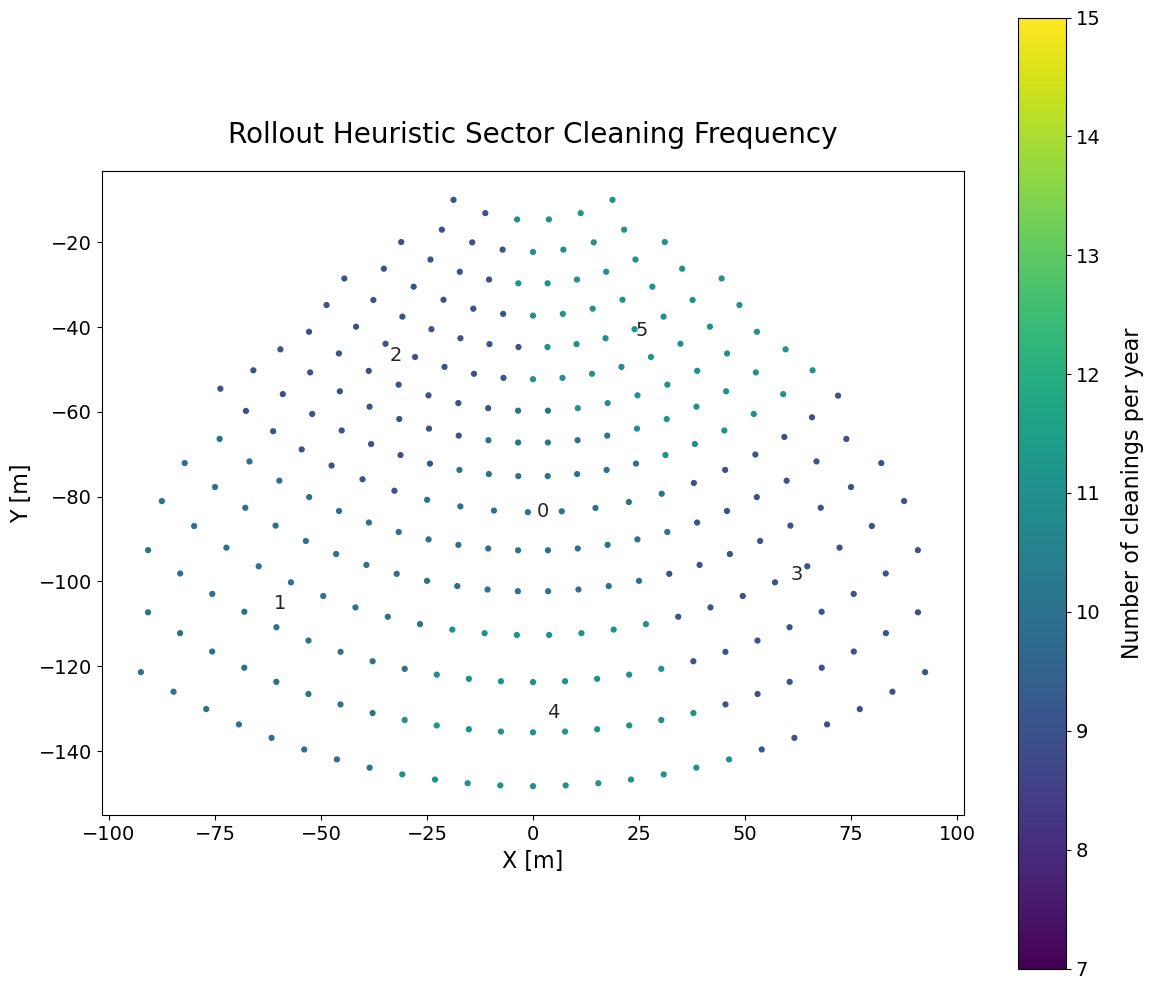

In [80]:
# Create a sector cleaning map detailing the number of cleanings per sector
helios = opt.field_model.helios
n_sectors = helios.tilt[f].shape[0]
c_map = plt.cm.get_cmap('viridis')
sid = helios.full_field['sector_id']
time_vector = opt.simulation_data.time[f]

# Create DataFrame of cleaning schedule with correct dimensions
cleaning_schedule = results_rollout['optimal_results']['cleaning_actions'][f]
df_cleaningschedule_rollout = pd.DataFrame(cleaning_schedule.T, index=time_vector)
vmax = np.max(np.sum(df_cleaningschedule_rollout, axis=0))
vmin = np.min(np.sum(df_cleaningschedule_rollout, axis=0))
# Adjust color range to enhance contrast
# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each sector
for ii in range(n_sectors):
    mask = sid == ii
    cleanings = np.sum(df_cleaningschedule_rollout.iloc[:,ii])
    
    # Plot heliostats in sector
    ax.scatter(helios.full_field['x'][mask], helios.full_field['y'][mask], 
              c=[cleanings] * np.sum(mask), 
              s=12, cmap=c_map, vmax=vmax, vmin=vmin)
    
    # Add sector ID label with larger font
    center_x = np.mean(helios.full_field['x'][mask])
    center_y = np.mean(helios.full_field['y'][mask])
    ax.text(center_x, center_y, str(ii), 
            alpha=0.85, ha='center', va='center', fontsize=14)

# Customize plot with larger fonts
ax.set_title('Rollout Heuristic Sector Cleaning Frequency', fontsize=20, pad=20)
ax.set_xlabel('X [m]', fontsize=16)
ax.set_ylabel('Y [m]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_aspect('equal')

# Add colorbar with enhanced styling
cbar = plt.colorbar(ax.collections[0])
cbar.set_label('Number of cleanings per year', fontsize=16, labelpad=15)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()